W1= (40, 12288)
b1= (40, 1)
W2= (40, 40)
b2= (40, 1)
W3= (40, 40)
b3= (40, 1)
W4= (40, 40)
b4= (40, 1)
W5= (1, 40)
b5= (1, 1)
epoches = 0  loss = 0.6884666254440425
epoches = 500  loss = 0.008672395093777348
epoches = 1000  loss = 0.0038877286083956056
epoches = 1500  loss = 0.002485939274670964


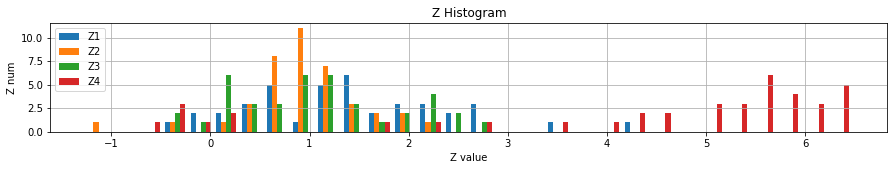

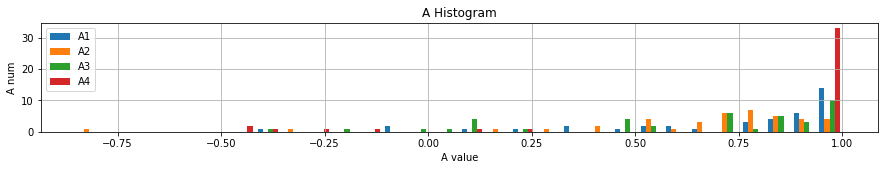

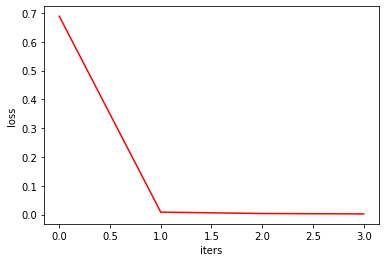

time cost: 322.734375 s
accuracy = 0.58


In [20]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time


def load_data():
    # File对象类似字典
    train_data = h5py.File('./dataset/train_catvnoncat.h5', 'r')
    test_data = h5py.File('./dataset/test_catvnoncat.h5', 'r')

    train_x = np.array(train_data['train_set_x'][:])
    train_y = np.array(train_data['train_set_y'][:])

    test_x = np.array(test_data['test_set_x'][:])
    test_y = np.array(test_data['test_set_y'][:])
    
    # reshape数据集
    # 特征：64 * 64 * 3 = 12288
    # (209, 64, 64, 3) -> (12288, 209)
    train_x = train_x.reshape(train_x.shape[0], -1).T
    test_x = test_x.reshape(test_x.shape[0], -1).T

    # (209, ) -> (1, 209)
    train_y = train_y.reshape(1, train_y.shape[0])
    test_y = test_y.reshape(1, test_y.shape[0])
    
    return train_x, train_y, test_x, test_y


def init_params(layers, activation='sigmoid', optimizer='gd'):
    # 根据传入的数组初始化每一层的W和b
    params = {}
    layer_num = len(layers)
    if optimizer == 'momentum' or optimizer == 'rmsprop':
        # momentum中的V和RMSProp中的S
        special_cache = {}
    
    for n in range(1, layer_num):
#         if activation == 'tanh':
#             # Xavier初始化，使W的方差等于上一层神经元个数的倒数
#             params['W'+str(n)] = np.random.randn(layers[n], layers[n-1]) * np.sqrt(1 / layers[n-1])
#         elif activation == 'ReLU':
#             # He初始化，ReLU激活函数的解决方案
#             params['W'+str(n)] = np.random.randn(layers[n], layers[n-1]) * np.sqrt(2 / layers[n-1])
#         else:
        params['W'+str(n)] = np.random.randn(layers[n], layers[n-1]) * 0.01  # 标准正态分布，*0.01将数据保持在±0.03之间
        params['b'+str(n)] = np.zeros((layers[n], 1))
        
        # BN的缩放因子和平移因子
        params['gamma'+str(n)] = np.ones((layers[n], 1))
        params['beta'+str(n)] = np.zeros((layers[n], 1))
        # 动态更新的均值和标准差，用于预测
        params['acc_mean'+str(n)] = np.zeros((layers[n], 1))
        params['acc_std'+str(n)] = np.zeros((layers[n], 1))
        
        if optimizer == 'momentum' or optimizer == 'rmsprop':
            special_cache['dW'+str(n)] = np.zeros((layers[n], layers[n-1]))
            special_cache['db'+str(n)] = np.zeros((layers[n], 1))
    
    for n in range(1, layer_num):
        print('W'+str(n)+'=', params['W'+str(n)].shape)
        print('b'+str(n)+'=', params['b'+str(n)].shape)
    
    if optimizer == 'momentum' or optimizer == 'rmsprop':
        return params, special_cache
    else:
        return params


def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))


def ReLU(Z):
    return np.maximum(0, Z)


def tanh(Z):
    return np.tanh(Z)
    
    
def sigmoid_grad(A):
    # s'(x) = s(x) * (1 - s(x))，所以此处是f(Z)而非Z
    return A * (1 - A)


def tanh_grad(A):
    return 1 - np.square(A)


def ReLU_grad(Z):
    return np.array(Z > 0)
    
    
def BN_forward(Z, bn_mode, params, n, epsilon=1e-8, eta=0.9): # n为层数
    # Z(Ln, m)
    Z_mean, Z_std = np.zeros((Z.shape[0], 1)), np.zeros((Z.shape[0], 1))
    Z_norm, Z_out = np.zeros(Z.shape), np.zeros(Z.shape)
    gamma, beta = params['gamma'+str(n)], params['gamma'+str(n)]
    if bn_mode == 'train':
        Z_mean = np.mean(Z, axis=1, keepdims=True)
        Z_std = np.std(Z, axis=1, keepdims=True)
        Z_norm = (Z - Z_mean) / (Z_std + epsilon)
        Z_out = gamma * Z_norm + beta
        params['acc_mean'+str(n)] = eta * params['acc_mean'+str(n)] + (1 - eta) * Z_mean
        params['acc_std'+str(n)] = eta * params['acc_std'+str(n)] + (1 - eta) * Z_std
    elif bn_mode == 'test':
        Z_norm = (Z - params['acc_mean'+str(n)]) / (params['acc_std'+str(n)] + epsilon)
        Z_out = gamma * Z_norm + beta
    else:
        print('bn_mode error!')
    
    return Z_out, Z_norm, Z_std, Z_mean, params
    

def forward_prop(X, params, use_bn, bn_mode, activation='sigmoid'):
    # 每一层WX+b的结果Z和激活后的结果A，用于反向传播
    # 要放入原始数据，即A0，否则反向传播会出问题
    cache = {'A0': X}
    bn_cache = {}
    A = X
    layer_num = len(params) // 6  # 用/会得到浮点数
    for n in range(1, layer_num):
        if use_bn:
            Z = np.dot(params['W'+str(n)], A)
            # BN
            Z, Z_norm, Z_std, Z_mean, params = BN_forward(Z, bn_mode, params, n)
            bn_cache['Z_mean'+str(n)] = Z_mean
            bn_cache['Z_std'+str(n)] = Z_std
            bn_cache['Z_norm'+str(n)] = Z_norm
        else:
            Z = np.dot(params['W'+str(n)], A) + params['b'+str(n)]
        A = eval(activation+'(Z)')
        cache['Z'+str(n)] = Z
        cache['A'+str(n)] = A
    
    # 最后一层使用sigmoid
    Z = np.dot(params['W'+str(layer_num)], A) + params['b'+str(layer_num)]
    A = sigmoid(Z)
    cache['Z'+str(layer_num)] = Z
    cache['A'+str(layer_num)] = A
    
    return A, cache, bn_cache, params
    
    
def mean_square_loss(A_last, Y):
    m = Y.shape[1]
    return np.sum((A_last - Y) * (A_last - Y)) / m / 2


def cross_entropy_loss(A_last, Y):
    m = Y.shape[1]
    return -np.sum(Y * np.log(A_last) + (1 - Y) * np.log(1 - A_last)) / m
    

def BN_backward(d_interY, bn_cache, params, n, epsilon=1e-8): # dJ / dy, 也就是经过BN层的Z的梯度
    m = d_interY.shape[1]
    gamma, beta = params['gamma'+str(n)], params['beta'+str(n)]
    Z_mean, Z_std, Z_norm = bn_cache['Z_mean'+str(n)], bn_cache['Z_std'+str(n)], bn_cache['Z_norm'+str(n)]
    
    d_gamma = np.sum(d_interY * Z_norm, axis=1, keepdims=True)
    d_beta = np.sum(d_interY, axis=1, keepdims=True)
    # dJ/dZ, 此处为输入的Z（BN前）
    d_Z = (gamma / (Z_std + epsilon)) * (d_interY - d_gamma * Z_norm / m - np.mean(d_interY, axis=1, keepdims=True))
    
    return d_gamma, d_beta, d_Z
    
    
def back_prop(Y, params, cache, bn_cache, use_bn, loss_type='cross_entropy', activation='sigmoid'):
    layer_num = len(params) // 6
    m = Y.shape[1]
    grads = {}  # 保存所有梯度
    
    # 最后一层的Z和A
    A_last = cache['A'+str(layer_num)]
    Z_last = cache['Z'+str(layer_num)]
    
    # 最后一层（输出层）dJ/dZ，且使用sigmoid
    dZ = A_last
    if loss_type == 'mean_square':
        dZ = (A_last - Y) * sigmoid_grad(A_last)
    elif loss_type == 'cross_entropy':
        dZ = -(np.divide(Y, A_last) - np.divide(1-Y, 1-A_last)) * sigmoid_grad(A_last)
    # 最后一层dJ/dW和dJ/db
    grads['dW'+str(layer_num)] = np.dot(dZ, cache['A'+str(layer_num-1)].T) / m
    # 在第二维求和（横向），保持二维
    grads['db'+str(layer_num)] = np.sum(dZ, axis=1, keepdims=True) / m
    
    for n in range(layer_num-1, 0, -1):
        if activation == 'ReLU':
            dZ = np.dot(params['W'+str(n+1)].T, dZ) * eval(activation + '_grad' + "(cache['Z'+str(n)])")
        else:
            dZ = np.dot(params['W'+str(n+1)].T, dZ) * eval(activation + '_grad' + "(cache['A'+str(n)])")
        # BN，此时传入的dZ为d_interY, 返回的dZ为真正的dZ
        if use_bn:
            d_gamma, d_beta, dZ = BN_backward(dZ, bn_cache, params, n)
            grads['d_gamma'+str(n)] = d_gamma
            grads['d_beta'+str(n)] = d_beta
            
        grads['dW'+str(n)] = np.dot(dZ, cache['A'+str(n-1)].T) / m
        # 无需更新b
        if not use_bn:
            grads['db'+str(n)] = np.sum(dZ, axis=1, keepdims=True) / m

    return grads
        

def gradient_descent(grads, params, lr, use_bn):
    # W = W - lr * dW，b相同
    layer_num = len(params) // 6
    if use_bn:
        # BN只作用于前3层
        for n in range(1, layer_num):
            params['W'+str(n)] = params['W'+str(n)] - lr * grads['dW'+str(n)]
            params['gamma'+str(n)] = params['gamma'+str(n)] - lr * grads['d_gamma'+str(n)]
            params['beta'+str(n)] = params['beta'+str(n)] - lr * grads['d_beta'+str(n)]
        # 最后一层
        params['W'+str(layer_num)] = params['W'+str(layer_num)] - lr * grads['dW'+str(layer_num)]
        params['b'+str(layer_num)] = params['b'+str(layer_num)] - lr * grads['db'+str(layer_num)]
    else:
        for n in range(1, layer_num+1):
            params['W'+str(n)] = params['W'+str(n)] - lr * grads['dW'+str(n)]
            params['b'+str(n)] = params['b'+str(n)] - lr * grads['db'+str(n)]

    return params


def momentum(grads, params, V, lr, momentum=0.9):
    # V = momentum * V + dW(db)
    # W = W - lr * V
    layer_num = len(params) // 6
    for n in range(1, layer_num+1):
        V['dW'+str(n)] = V['dW'+str(n)] * momentum + grads['dW'+str(n)]
        params['W'+str(n)] = params['W'+str(n)] - lr * V['dW'+str(n)]
        
        V['db'+str(n)] = V['db'+str(n)] * momentum + grads['db'+str(n)]
        params['b'+str(n)] = params['b'+str(n)] - lr * V['db'+str(n)]
        
    return params, V


def RMSProp(grads, params, S, lr, decay=0.9, epsilon=1e-8):
    # S = decay * S + (1 - decay) * square(dW)
    # W = W - lr / sqrt(S + epsilon) * dW
    layer_num = len(params) // 6
    for n in range(1, layer_num+1):
        S['dW'+str(n)] = S['dW'+str(n)] * decay + np.square(grads['dW'+str(n)]) * (1 - decay)
        params['W'+str(n)] = params['W'+str(n)] - lr / np.sqrt(S['dW'+str(n)] + epsilon) * grads['dW'+str(n)]
        
        S['db'+str(n)] = S['db'+str(n)] * decay + np.square(grads['db'+str(n)]) * (1 - decay)
        params['b'+str(n)] = params['b'+str(n)] - lr / np.sqrt(S['db'+str(n)] + epsilon) * grads['db'+str(n)]
        
    return params, S

    
def divide_data(train_x, train_y, batch_size=64):
    m = train_x.shape[1]
    # 打乱数据集
    permutation = np.random.permutation(m).tolist() # 获得一个0-m-1的随机序列
    X_shuffled = train_x[:, permutation]
    y_shuffled = train_y[:, permutation]
    mini_batches = []
    # 分批次
    batch_num = m // batch_size
    for i in range(batch_num):
        mini_batch_X = X_shuffled[:, i*batch_size : (i+1)*batch_size]
        mini_batch_y = y_shuffled[:, i*batch_size : (i+1)*batch_size]
        mini_batches.append((mini_batch_X, mini_batch_y))
    # 多余的样本
    if m % batch_size != 0:
        mini_batch_X = X_shuffled[:, (i+1)*batch_size:]
        mini_batch_y = y_shuffled[:, (i+1)*batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_y))
        
    return mini_batches
    

def train(layers, train_x, train_y, use_bn=False, bn_mode='train', loss_type='cross_entropy', 
          batch_size=64, epoches=500, lr=0.01, activation='sigmoid', optimizer='gd'):
    # 初始化w和b
    if optimizer == 'momentum' or optimizer == 'rmsprop':
        params, special_cache = init_params(layers, activation, optimizer)
    else:
        params = init_params(layers, activation, optimizer)

    losses = []
    
    for epoch in range(epoches):
        # 应该每个epoch都对数据集进行随机打乱
        mini_batches = divide_data(train_x, train_y, batch_size)
        
        for mini_batch in mini_batches:
            mini_batch_X, mini_batch_y = mini_batch
            # 前向传播, A_last(1, 209)
            A_last, cache, bn_cache, params = forward_prop(mini_batch_X, params, use_bn, bn_mode, activation)

            # 计算loss
            if loss_type == 'cross_entropy':
                loss = cross_entropy_loss(A_last, mini_batch_y)
            elif loss_type == 'mean_square':
                loss = mean_square_loss(A_last, mini_batch_y)
            if epoch % 500 == 0:
                print('epoches =', epoch, ' loss =', loss)
                losses.append(loss)

            # 反向传播
            grads = back_prop(mini_batch_y, params, cache, bn_cache, use_bn, loss_type, activation)
            
            # 梯度下降更新参数
            if optimizer == 'momentum':
                params, V = momentum(grads, params, special_cache, lr)
            elif optimizer == 'rmsprop':
                params, S = RMSProp(grads, params, special_cache, lr)
            else:
                params = gradient_descent(grads, params, lr, use_bn)
            
            # 画图
            if epoch == epoches - 1:
                # 此处的Z是经过BN层的Z，即inter_Y
                Zs = [cache['Z1'][:, 1], cache['Z2'][:, 1], cache['Z3'][:, 1], cache['Z4'][:, 1]]
                plt.figure(figsize=(15, 2))
                plt.hist(Zs, bins=30, label=['Z1', 'Z2', 'Z3', 'Z4'])
                plt.grid(True)
                plt.legend(loc=0)
                plt.xlabel('Z value')
                plt.ylabel('Z num')
                plt.title('Z Histogram')
                
                As = [cache['A1'][:, 1], cache['A2'][:, 1], cache['A3'][:, 1], cache['A4'][:, 1]]
                plt.figure(figsize=(15, 2))
                plt.hist(As, bins=30, label=['A1', 'A2', 'A3', 'A4'])
                plt.grid(True)
                plt.legend(loc=0)
                plt.xlabel('A value')
                plt.ylabel('A num')
                plt.title('A Histogram')
                
                plt.show()
                

    plt.plot(losses, 'r')
    plt.xlabel('iters')
    plt.ylabel('loss')
    plt.show()
    
    return params


def predict(X, Y, params, use_bn, bn_mode='test', activation='sigmoid'):
    m = X.shape[1] # 样本数量
    A_last, _0, _1, _2 = forward_prop(X, params, use_bn, bn_mode, activation)
    result = np.zeros(A_last.shape)
    for i in range(A_last.shape[1]):
        if A_last[0][i] >= 0.5:
            result[0][i] = 1
        else:
            result[0][i] = 0
    acc = np.sum(result==Y) / m
    print('accuracy =', acc)
    
    
    
if __name__ == '__main__':
    train_x, train_y, test_x, test_y = load_data()
    # 归一化
    train_x = train_x / 255.0
    test_x = test_x / 255.0
    
#     layers = [12288, 10, 3, 2, 1]
    layers = [12288, 40, 40, 40, 40, 1]
#     layers = [12288, 10, 1]
    start = time.process_time()
    params = train(layers, train_x, train_y, use_bn=True, batch_size=209, epoches=2000, lr=0.01, activation='tanh', optimizer='gd')
    end = time.process_time()
    print('time cost:', end - start, 's')
    
    predict(test_x, test_y, params, use_bn=True, activation='tanh')
    
    
    
    

4
